In [29]:
import pandas as pd
import numpy as np
import os
import json
import re

In [30]:
NUM_VERSIONS = 3
NUM_QUESTIONS = 5

In [31]:
# open dir ../configs
# Get the current working directory of the notebook
notebook_path = os.getcwd()


# Collect all answer DataFrames for each version
all_answers_versions = [[] for _ in range(NUM_VERSIONS * NUM_QUESTIONS)]
json_files_versions = [[] for _ in range(NUM_VERSIONS * NUM_QUESTIONS)]


for question_index in range(NUM_QUESTIONS):

    config_path = os.path.join(notebook_path, f"../config/configs_{question_index}")

    print(config_path)

    # get name of all subdirectories in ../configs
    subdirs = [
        d
        for d in os.listdir(config_path)
        if os.path.isdir(os.path.join(config_path, d))
    ]

    print(subdirs)

    for subdir in subdirs:
        subdir_path = os.path.join(config_path, subdir)
        config_file = os.path.join(subdir_path, "config_0.json")
        try:
            with open(config_file, "r") as file:
                config_data = json.load(file)
            config_df = pd.json_normalize(config_data)
            party_1 = config_df["persons"][0][0]["party"]
            party_2 = config_df["persons"][0][1]["party"]
            namme_1 = config_df["persons"][0][0]["name"]
            namme_2 = config_df["persons"][0][1]["name"]

        except Exception as e:
            print(f"Error reading {config_file}: {e}")
            continue

        for v in range(NUM_VERSIONS):
            json_file = os.path.join(subdir_path, f"out_v{v}.json")
            if os.path.isfile(json_file):
                json_files_versions[v].append(json_file)
            else:
                continue
            try:
                with open(json_file, "r") as file:
                    data = json.load(file)
            except Exception as e:
                print(f"Error reading {json_file}: {e}")
                continue

            columns = {}
            columns["question_index"] = question_index
            columns["party_1"] = party_1
            columns["party_2"] = party_2

            for q in data["survey_question"]:
                name = q["chat_entry"]["entity"]["name"]
                name = "agent_1" if name == namme_1 else "agent_2"
                iteration = q["iteration"]
                col_name = f"{name}_T{iteration}"
                columns[col_name] = q["chat_entry"]["answer"]

            answers_df = pd.DataFrame([columns])

            all_answers_versions[v + question_index * NUM_VERSIONS].append(answers_df)

/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config/configs_0
['CDU_CSU-AfD', 'Bündnis_90_Die_Grünen-Nicht_gewählt', 'Bündnis_90_Die_Grünen-AfD', 'Die_Linke-FDP', 'SPD-SPD', 'Die_Linke-Nicht_gewählt', 'Die_Linke-Die_Linke', 'FDP-FDP', 'AfD-AfD', 'Bündnis_90_Die_Grünen-Bündnis_90_Die_Grünen', 'SPD-AfD', 'FDP-Nicht_gewählt', 'Die_Linke-Bündnis_90_Die_Grünen', 'CDU_CSU-CDU_CSU', 'FDP-AfD', 'CDU_CSU-Nicht_gewählt', 'AfD-Nicht_gewählt', 'SPD-Nicht_gewählt', 'SPD-Bündnis_90_Die_Grünen', 'Bündnis_90_Die_Grünen-FDP', 'Die_Linke-AfD', 'Die_Linke-CDU_CSU', 'Nicht_gewählt-Nicht_gewählt', 'Bündnis_90_Die_Grünen-CDU_CSU', 'Die_Linke-SPD', 'SPD-CDU_CSU', 'SPD-FDP', 'FDP-CDU_CSU']
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config/configs_1
['CDU_CSU-AfD', 'Bündnis_90_Die_Grünen-Nicht_gewählt', 'Bündnis_90_Die_Grünen-AfD', 'Die_Linke-FDP', 'SPD-SPD', 'Die_Linke-Nicht_gewählt', 'Die_Linke-Die_Linke', 'FDP-FDP', 'AfD-AfD', 'Bündnis_90_Die_Grünen-Bündnis_90_Die_Grünen', 'SPD-AfD', 'FDP-Ni

In [32]:
big_dfs = []
for v in range(NUM_VERSIONS * NUM_QUESTIONS):
    if all_answers_versions[v]:
        # print(f"all_answers_versions[{v}]: {all_answers_versions[v]}")
        big_df = pd.concat(all_answers_versions[v], ignore_index=True)
        big_dfs.append(big_df)

        display(big_df)

        init_opinions: pd.DataFrame = big_df[["agent_1_T0", "agent_2_T0"]].copy()
        init_opinions = init_opinions.apply(pd.to_numeric, errors="coerce")
        init_opinions = init_opinions.dropna()
        init_opinions = init_opinions.astype(float)
        init_opinions = (
            init_opinions["agent_1_T0"].tolist() + init_opinions["agent_2_T0"].tolist()
        )
        init_mean = np.mean(init_opinions)
        init_std = np.std(init_opinions)
        print(f"Initial mean for version {v}: {init_mean}")
        print(f"Initial std for version {v}: {init_std}")

        last_opinions: pd.DataFrame = big_df[["agent_1_T20", "agent_2_T20"]].copy()
        last_opinions = last_opinions.apply(pd.to_numeric, errors="coerce")
        last_opinions = last_opinions.dropna()
        last_opinions = last_opinions.astype(float)
        last_mean = np.mean(last_opinions)
        last_std = np.std(last_opinions)
        print(f"Last mean for version {v}: {last_mean}")
        print(f"Last std for version {v}: {last_std}")

    else:
        print(f"No dataframes to concatenate for version {v}.")

# print(v)

,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,0,CDU/CSU,AfD,7,7,8,7,7,7,8,7,7,7,7,7
1,0,Bündnis 90/Die Grünen,Nicht gewählt,7,7,7,6,7,6,7,6,7,6,7,6
2,0,Bündnis 90/Die Grünen,AfD,7,6,7,5,7,4,7,4,7,5,7,5
3,0,Die Linke,FDP,9,7,9,6,9,7,9,7,9,7,9,7
4,0,SPD,SPD,7,7,7,7,7,7,7,7,7,7,7,7
5,0,Die Linke,Nicht gewählt,9,7,9,4,8,4,8,5,8,5,8,5
6,0,Die Linke,Die Linke,9,8,9,8,9,8,9,9,10,9,9,9
7,0,FDP,FDP,4,7,5,7,5,6,5,7,5,7,6,7
8,0,AfD,AfD,4,7,7,6,7,6,7,6,7,7,7,6
9,0,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,6,8,7,8,7,8,7,8,7,8,7,8


Initial mean for version 0: 6.75
Initial std for version 0: 1.3919410907075054
Last mean for version 0: 7.125
Last std for version 0: agent_1_T20    1.117463
agent_2_T20    1.263700
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,0,CDU/CSU,AfD,7,6,8,7,8,7,8,7,8,7,8,8
1,0,Bündnis 90/Die Grünen,Nicht gewählt,7,7,7,7,8,8,8,8,8,8,8,8
2,0,Bündnis 90/Die Grünen,AfD,7,6,7,5,7,5,7,5,7,6,7,5
3,0,Die Linke,FDP,9,7,9,7,8,7,8,7,8,7,8,7
4,0,SPD,SPD,7,7,7,6,7,7,7,7,7,6,7,7
5,0,Die Linke,Nicht gewählt,9,7,8,4,8,4,8,6,8,5,8,5
6,0,Die Linke,Die Linke,9,8,9,8,9,8,9,9,9,9,9,9
7,0,FDP,FDP,4,7,6,7,6,7,6,7,6,7,6,7
8,0,AfD,AfD,3,6,6,7,7,7,7,7,7,7,7,7
9,0,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,7,8,8,9,8,9,8,9,8,9,8,9


Initial mean for version 1: 6.75
Initial std for version 1: 1.3919410907075054
Last mean for version 1: 7.053571428571429
Last std for version 1: agent_1_T20    0.981331
agent_2_T20    1.394230
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,0,CDU/CSU,AfD,7,6,7,6,7,6,7,6,7,6,7,6
1,0,Bündnis 90/Die Grünen,Nicht gewählt,6,7,7,5,7,6,7,6,7,6,7,6
2,0,Bündnis 90/Die Grünen,AfD,6,6,8,7,7,7,8,7,7,7,7,7
3,0,Die Linke,FDP,9,7,8,6,9,7,9,7,9,7,9,7
4,0,SPD,SPD,7,7,8,8,8,8,8,8,9,8,9,8
5,0,Die Linke,Nicht gewählt,9,6,9,6,9,5,9,6,9,6,9,6
6,0,Die Linke,Die Linke,9,8,9,8,9,9,9,9,9,9,9,9
7,0,FDP,FDP,6,7,4,6,6,6,5,6,6,7,5,6
8,0,AfD,AfD,3,7,6,6,6,7,7,7,7,7,6,7
9,0,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,6,8,7,8,8,8,7,8,8,8,7,8


Initial mean for version 2: 6.767857142857143
Initial std for version 2: 1.281615490428437
Last mean for version 2: 7.053571428571429
Last std for version 2: agent_1_T20    1.210077
agent_2_T20    1.422756
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,1,CDU/CSU,AfD,5,6,5,6,5,5,6,5,6,6,5,5
1,1,Bündnis 90/Die Grünen,Nicht gewählt,6,4,7,5,7,6,7,6,6,6,7,6
2,1,Bündnis 90/Die Grünen,AfD,4,6,6,6,6,6,6,6,6,6,6,6
3,1,Die Linke,FDP,2,6,2,5,3,6,2,6,2,6,3,5
4,1,SPD,SPD,4,5,5,6,5,6,5,6,5,6,5,6
5,1,Die Linke,Nicht gewählt,2,4,3,6,3,7,3,7,3,6,3,6
6,1,Die Linke,Die Linke,2,3,2,3,2,3,2,3,2,3,2,3
7,1,FDP,FDP,6,6,6,6,6,6,6,6,6,6,6,6
8,1,AfD,AfD,6,6,7,6,7,6,7,6,7,6,7,6
9,1,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,6,4,6,4,6,5,6,4,6,4,6,4


Initial mean for version 3: 4.678571428571429
Initial std for version 3: 1.377201391761346
Last mean for version 3: 5.321428571428571
Last std for version 3: agent_1_T20    1.569398
agent_2_T20    1.012045
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,1,CDU/CSU,AfD,6,6,6,5,6,6,6,6,6,6,6,6
1,1,Bündnis 90/Die Grünen,Nicht gewählt,6,4,6,5,6,5,6,5,6,5,6,6
2,1,Bündnis 90/Die Grünen,AfD,5,6,5,6,6,6,5,6,6,6,5,6
3,1,Die Linke,FDP,2,6,2,6,2,5,2,5,2,5,2,5
4,1,SPD,SPD,4,5,3,3,3,3,3,3,3,3,3,3
5,1,Die Linke,Nicht gewählt,2,6,3,6,3,6,3,6,3,6,3,6
6,1,Die Linke,Die Linke,2,3,2,3,2,3,2,3,2,3,2,3
7,1,FDP,FDP,6,5,6,5,6,5,5,5,5,5,5,5
8,1,AfD,AfD,6,6,7,7,7,7,7,7,7,7,7,6
9,1,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,6,4,6,5,6,6,6,5,6,5,6,5


Initial mean for version 4: 4.714285714285714
Initial std for version 4: 1.385051387833237
Last mean for version 4: 5.178571428571429
Last std for version 4: agent_1_T20    1.697462
agent_2_T20    1.238725
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,1,CDU/CSU,AfD,5,6,5,5,5,6,5,5,6,6,5,6
1,1,Bündnis 90/Die Grünen,Nicht gewählt,6,3,6,6,6,5,7,6,7,6,6,5
2,1,Bündnis 90/Die Grünen,AfD,6,6,6,6,6,6,6,6,6,6,6,6
3,1,Die Linke,FDP,2,6,2,6,2,5,2,5,2,5,2,5
4,1,SPD,SPD,4,4,3,3,3,3,3,3,3,3,3,3
5,1,Die Linke,Nicht gewählt,2,6,3,5,3,6,3,6,3,6,4,6
6,1,Die Linke,Die Linke,2,3,2,3,2,3,2,2,2,3,2,3
7,1,FDP,FDP,6,5,6,6,7,6,7,6,7,6,6,6
8,1,AfD,AfD,7,5,7,6,7,6,7,6,7,6,7,6
9,1,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,6,4,6,4,6,5,6,4,6,4,6,5


Initial mean for version 5: 4.767857142857143
Initial std for version 5: 1.4637411879516553
Last mean for version 5: 5.232142857142857
Last std for version 5: agent_1_T20    1.581139
agent_2_T20    1.051602
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,2,CDU/CSU,AfD,6,4,7,3,7,4,7,6,7,6,8,5
1,2,Bündnis 90/Die Grünen,Nicht gewählt,4,4,4,7,4,7,5,7,6,7,6,7
2,2,Bündnis 90/Die Grünen,AfD,6,3,4,6,4,7,4,7,5,7,4,7
3,2,Die Linke,FDP,9,7,9,6,9,7,9,7,9,7,9,7
4,2,SPD,SPD,6,7,7,8,7,8,8,8,8,8,8,8
5,2,Die Linke,Nicht gewählt,9,4,9,4,8,4,9,6,8,6,9,6
6,2,Die Linke,Die Linke,8,7,9,8,9,9,9,9,9,9,9,9
7,2,FDP,FDP,6,6,7,8,7,8,7,8,8,8,8,8
8,2,AfD,AfD,3,4,3,6,3,6,3,6,3,6,3,6
9,2,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,4,8,4,8,6,8,6,8,6,8,6,8


Initial mean for version 6: 5.660714285714286
Initial std for version 6: 1.854307588468823
Last mean for version 6: 7.160714285714286
Last std for version 6: agent_1_T20    1.499575
agent_2_T20    1.432138
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,2,CDU/CSU,AfD,5,4,4,7,5,7,6,7,6,7,6,7
1,2,Bündnis 90/Die Grünen,Nicht gewählt,4,4,4,7,6,7,6,7,6,7,6,7
2,2,Bündnis 90/Die Grünen,AfD,4,3,7,3,6,4,7,4,6,4,6,4
3,2,Die Linke,FDP,9,6,8,5,9,6,9,6,9,6,8,6
4,2,SPD,SPD,7,7,7,8,7,8,8,9,7,8,8,9
5,2,Die Linke,Nicht gewählt,8,6,9,7,9,7,9,7,9,7,9,7
6,2,Die Linke,Die Linke,9,8,9,8,9,9,9,9,9,9,9,9
7,2,FDP,FDP,6,6,4,7,5,7,4,7,5,7,5,7
8,2,AfD,AfD,3,4,3,6,5,8,6,7,6,7,7,7
9,2,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,4,8,4,8,5,8,4,8,4,8,5,8


Initial mean for version 7: 5.625
Initial std for version 7: 1.8666480653835098
Last mean for version 7: 7.053571428571429
Last std for version 7: agent_1_T20    1.465157
agent_2_T20    1.307358
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,2,CDU/CSU,AfD,6,4,7,4,7,4,7,4,7,4,7,5
1,2,Bündnis 90/Die Grünen,Nicht gewählt,4,4,3,7,6,7,5,7,6,7,5,7
2,2,Bündnis 90/Die Grünen,AfD,4,3,4,6,4,6,4,6,6,7,6,7
3,2,Die Linke,FDP,9,6,9,7,9,7,9,7,9,7,9,7
4,2,SPD,SPD,6,7,8,8,8,9,8,9,8,9,8,9
5,2,Die Linke,Nicht gewählt,9,6,8,8,9,7,9,8,9,8,9,8
6,2,Die Linke,Die Linke,9,7,9,8,9,9,9,9,9,9,9,9
7,2,FDP,FDP,7,6,7,7,8,8,7,8,8,8,8,8
8,2,AfD,AfD,4,3,3,3,4,4,3,3,4,3,4,4
9,2,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,5,8,7,9,7,9,6,9,7,9,7,9


Initial mean for version 8: 5.660714285714286
Initial std for version 8: 1.765510708329035
Last mean for version 8: 7.125
Last std for version 8: agent_1_T20    1.287697
agent_2_T20    1.739033
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,3,CDU/CSU,AfD,2,6,2,3,2,3,2,3,2,3,2,3
1,3,Bündnis 90/Die Grünen,Nicht gewählt,2,3,2,2,2,2,2,3,2,2,2,2
2,3,Bündnis 90/Die Grünen,AfD,3,4,3,3,2,3,2,2,3,3,3,3
3,3,Die Linke,FDP,1,3,0,0,0,1,0,0,0,0,0,0
4,3,SPD,SPD,3,2,1,1,0,1,1,1,1,1,1,1
5,3,Die Linke,Nicht gewählt,1,3,0,2,0,2,0,2,0,3,0,2
6,3,Die Linke,Die Linke,0,2,0,0,0,0,0,0,0,0,0,0
7,3,FDP,FDP,3,2,2,2,2,2,2,2,2,1,1,2
8,3,AfD,AfD,7,6,3,2,3,2,3,2,2,2,3,2
9,3,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,2,1,2,1,2,1,2,1,2,1,2,2


Initial mean for version 9: 2.9464285714285716
Initial std for version 9: 1.6628250794650528
Last mean for version 9: 1.6964285714285714
Last std for version 9: agent_1_T20    0.944236
agent_2_T20    0.960973
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,3,CDU/CSU,AfD,2,7,1,2,1,2,1,3,2,2,1,3
1,3,Bündnis 90/Die Grünen,Nicht gewählt,3,3,3,2,2,3,2,3,2,2,2,3
2,3,Bündnis 90/Die Grünen,AfD,3,4,2,3,2,3,2,3,3,3,2,2
3,3,Die Linke,FDP,1,3,0,0,0,0,0,1,0,0,0,1
4,3,SPD,SPD,2,2,0,1,0,1,1,1,1,1,1,1
5,3,Die Linke,Nicht gewählt,0,6,0,2,1,3,0,3,0,2,1,3
6,3,Die Linke,Die Linke,0,2,0,0,0,0,0,0,0,0,0,0
7,3,FDP,FDP,4,2,2,2,3,2,2,3,2,2,3,2
8,3,AfD,AfD,6,6,3,3,3,3,3,3,3,3,2,3
9,3,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,2,1,2,1,2,1,3,1,2,2,2,1


Initial mean for version 10: 2.9642857142857144
Initial std for version 10: 1.9082928581989351
Last mean for version 10: 1.5714285714285714
Last std for version 10: agent_1_T20    0.927884
agent_2_T20    0.965608
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,3,CDU/CSU,AfD,2,7,2,3,1,2,2,3,2,3,2,3
1,3,Bündnis 90/Die Grünen,Nicht gewählt,2,3,1,1,0,0,0,0,1,0,0,0
2,3,Bündnis 90/Die Grünen,AfD,3,7,2,3,3,2,2,3,2,3,2,2
3,3,Die Linke,FDP,1,3,0,1,0,2,0,2,0,1,0,2
4,3,SPD,SPD,2,2,1,1,0,1,1,0,1,0,0,1
5,3,Die Linke,Nicht gewählt,0,3,0,1,0,1,0,0,0,1,0,1
6,3,Die Linke,Die Linke,0,2,0,0,0,0,0,0,0,0,0,0
7,3,FDP,FDP,4,3,2,2,2,2,2,2,2,2,2,2
8,3,AfD,AfD,7,6,3,3,2,2,2,2,3,2,2,2
9,3,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,3,1,2,1,2,2,3,1,3,1,2,1


Initial mean for version 11: 2.9464285714285716
Initial std for version 11: 1.78705306957275
Last mean for version 11: 1.5535714285714286
Last std for version 11: agent_1_T20    1.001911
agent_2_T20    0.939496
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,4,CDU/CSU,AfD,7,7,7,7,7,7,7,7,7,7,7,7
1,4,Bündnis 90/Die Grünen,Nicht gewählt,7,7,7,7,7,7,7,7,7,7,7,7
2,4,Bündnis 90/Die Grünen,AfD,7,6,7,6,7,7,7,7,7,7,7,7
3,4,Die Linke,FDP,9,7,9,7,9,7,9,7,9,7,9,7
4,4,SPD,SPD,8,7,8,8,8,8,8,8,8,8,9,8
5,4,Die Linke,Nicht gewählt,9,6,9,6,8,7,9,6,9,6,9,6
6,4,Die Linke,Die Linke,9,8,9,8,9,8,9,8,9,8,9,8
7,4,FDP,FDP,3,7,6,7,6,7,6,7,6,7,6,7
8,4,AfD,AfD,7,6,7,6,7,6,7,7,7,6,7,7
9,4,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,7,8,7,8,8,8,8,8,8,8,8,8


Initial mean for version 12: 6.982142857142857
Initial std for version 12: 1.3821705423583825
Last mean for version 12: 7.464285714285714
Last std for version 12: agent_1_T20    1.186661
agent_2_T20    0.883523
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,4,CDU/CSU,AfD,7,6,7,6,7,7,8,7,8,7,8,7
1,4,Bündnis 90/Die Grünen,Nicht gewählt,7,6,7,6,8,7,8,7,8,7,8,7
2,4,Bündnis 90/Die Grünen,AfD,7,6,7,6,7,6,7,6,7,6,7,6
3,4,Die Linke,FDP,9,7,9,7,9,7,9,7,9,7,9,7
4,4,SPD,SPD,8,7,8,7,8,7,8,7,8,7,8,7
5,4,Die Linke,Nicht gewählt,9,7,8,6,9,7,9,7,9,7,9,7
6,4,Die Linke,Die Linke,9,8,9,8,9,8,10,9,9,8,10,9
7,4,FDP,FDP,6,7,6,7,6,7,7,7,7,7,7,7
8,4,AfD,AfD,7,6,7,6,7,6,7,6,7,6,7,6
9,4,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,7,8,7,8,8,9,8,8,8,9,8,9


Initial mean for version 13: 7.053571428571429
Initial std for version 13: 1.2308481810921925
Last mean for version 13: 7.446428571428571
Last std for version 13: agent_1_T20    1.144530
agent_2_T20    0.963624
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,4,CDU/CSU,AfD,7,7,8,7,8,7,8,7,8,7,8,7
1,4,Bündnis 90/Die Grünen,Nicht gewählt,7,7,7,7,7,7,7,7,7,7,7,7
2,4,Bündnis 90/Die Grünen,AfD,7,7,7,7,7,7,7,7,7,7,7,7
3,4,Die Linke,FDP,9,7,9,8,9,8,9,8,9,8,9,8
4,4,SPD,SPD,8,7,8,8,8,8,9,8,8,8,8,8
5,4,Die Linke,Nicht gewählt,9,7,9,6,9,6,9,6,9,6,8,6
6,4,Die Linke,Die Linke,9,8,9,8,9,8,9,9,9,9,9,9
7,4,FDP,FDP,4,7,4,7,6,7,5,7,5,7,6,7
8,4,AfD,AfD,7,6,6,7,6,6,6,7,7,6,6,7
9,4,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,7,8,7,8,7,8,7,8,7,8,7,8


Initial mean for version 14: 7.035714285714286
Initial std for version 14: 1.2672282142292979
Last mean for version 14: 7.482142857142857
Last std for version 14: agent_1_T20    1.196828
agent_2_T20    0.920293
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [33]:
# Helper function to process big_df into long format with agent_idx
def process_big_df(big_df, version_label, question_index):
    t_row = ["party", "debate_with"]
    for i in range(0, 11):
        t_row.append(f"T{i}")
    formated_df = pd.DataFrame(columns=t_row)
    for row in big_df.iterrows():
        party_1 = row[1]["party_1"]
        party_2 = row[1]["party_2"]

        # agent_1 row
        agent_1_data = row[1].filter(like="agent_1")
        agent_1_data.index = agent_1_data.index.str.replace("agent_1_", "")
        agent_1_data = agent_1_data.rename(party_1)
        agent_1_data = agent_1_data.to_frame().T
        agent_1_data.insert(0, "debate_with", party_2)
        agent_1_data.insert(0, "party", party_1)
        formated_df = pd.concat([formated_df, agent_1_data], ignore_index=True)
        # agent_2 row
        agent_2_data = row[1].filter(like="agent_2")
        agent_2_data.index = agent_2_data.index.str.replace("agent_2_", "")
        agent_2_data = agent_2_data.rename(party_2)
        agent_2_data = agent_2_data.to_frame().T
        agent_2_data.insert(0, "debate_with", party_1)
        agent_2_data.insert(0, "party", party_2)
        formated_df = pd.concat([formated_df, agent_2_data], ignore_index=True)
    formated_df = formated_df.reset_index(drop=True)
    for col in formated_df.columns:
        if col.startswith("T"):

            def extract_number(text):
                if pd.isna(text):
                    return None
                if isinstance(text, (int, float)):
                    return text
                text = str(text)
                numbers = re.findall(r"\d+", text)
                if numbers:
                    return int(numbers[0])
                else:
                    return None

            formated_df[col] = formated_df[col].apply(extract_number)

    formated_df["version"] = version_label
    formated_df["question_index"] = question_index

    return formated_df


formated_df_all = []
for question_index in range(NUM_QUESTIONS):
    for v in range(NUM_VERSIONS):
        version_label = f"out_{v}"
        # Only process if big_dfs has data for this version
        if v < len(big_dfs):
            formated_df_all.append(
                process_big_df(
                    big_dfs[v + question_index * NUM_VERSIONS],
                    version_label,
                    question_index,
                )
            )
        else:
            print(f"Skipping version {version_label} due to missing data.")

if formated_df_all:
    formated_df_all = pd.concat(formated_df_all, ignore_index=True)
else:
    formated_df_all = pd.DataFrame()


print("Formatted DataFrame:")
display(formated_df_all)


# Calculate the difference between Tn and T0 for all T1-T10 columns
def calculate_abs_differences(df):

    for i in range(1, 11):
        col_name = f"T{i}"
        prev_col_name = "T0"
        # Ensure both columns are numeric before subtraction
        df[col_name] = abs(
            pd.to_numeric(df[col_name], errors="coerce")
            - pd.to_numeric(df[prev_col_name], errors="coerce")
        )

    df["T0"] = 0  # Set T0 to 0 for consistency

    return df


formated_df_non_abs = formated_df_all.copy()
formated_df_all = calculate_abs_differences(formated_df_all)


if not formated_df_all.empty:
    party_df = formated_df_all.melt(
        id_vars=["party", "debate_with", "version", "question_index"],
        var_name="iteration",
        value_name="answer",
    )
    party_df = party_df.dropna(subset=["answer"]).reset_index(drop=True)
    display(party_df)
else:
    print("No formatted dataframes to process.")

if not formated_df_non_abs.empty:
    party_df_non_abs = formated_df_non_abs.melt(
        id_vars=["party", "debate_with", "version", "question_index"],
        var_name="iteration",
        value_name="answer",
    )
    party_df_non_abs = party_df_non_abs.dropna(subset=["answer"]).reset_index(drop=True)
    display(party_df_non_abs)
else:
    print("No formatted dataframes to process.")

Formatted DataFrame:


,party,debate_with,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T12,T16,T20,version,question_index
0,CDU/CSU,AfD,7,None,None,None,8,None,None,None,7,None,None,8,7,7,out_0,0
1,AfD,CDU/CSU,7,None,None,None,7,None,None,None,7,None,None,7,7,7,out_0,0
2,Bündnis 90/Die Grünen,Nicht gewählt,7,None,None,None,7,None,None,None,7,None,None,7,7,7,out_0,0
3,Nicht gewählt,Bündnis 90/Die Grünen,7,None,None,None,6,None,None,None,6,None,None,6,6,6,out_0,0
4,Bündnis 90/Die Grünen,AfD,7,None,None,None,7,None,None,None,7,None,None,7,7,7,out_0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,CDU/CSU,SPD,7,None,None,None,7,None,None,None,8,None,None,8,8,8,out_2,4
836,SPD,FDP,8,None,None,None,8,None,None,None,8,None,None,8,8,8,out_2,4
837,FDP,SPD,7,None,None,None,7,None,None,None,7,None,None,7,7,7,out_2,4
838,FDP,CDU/CSU,4,None,None,None,6,None,None,None,6,None,None,6,6,6,out_2,4


,party,debate_with,version,question_index,iteration,answer
0,CDU/CSU,AfD,out_0,0,T0,0.0
1,AfD,CDU/CSU,out_0,0,T0,0.0
2,Bündnis 90/Die Grünen,Nicht gewählt,out_0,0,T0,0.0
3,Nicht gewählt,Bündnis 90/Die Grünen,out_0,0,T0,0.0
4,Bündnis 90/Die Grünen,AfD,out_0,0,T0,0.0
...,...,...,...,...,...,...
5035,CDU/CSU,SPD,out_2,4,T20,8.0
5036,SPD,FDP,out_2,4,T20,8.0
5037,FDP,SPD,out_2,4,T20,7.0
5038,FDP,CDU/CSU,out_2,4,T20,6.0


,party,debate_with,version,question_index,iteration,answer
0,CDU/CSU,AfD,out_0,0,T0,7
1,AfD,CDU/CSU,out_0,0,T0,7
2,Bündnis 90/Die Grünen,Nicht gewählt,out_0,0,T0,7
3,Nicht gewählt,Bündnis 90/Die Grünen,out_0,0,T0,7
4,Bündnis 90/Die Grünen,AfD,out_0,0,T0,7
...,...,...,...,...,...,...
5035,CDU/CSU,SPD,out_2,4,T20,8
5036,SPD,FDP,out_2,4,T20,8
5037,FDP,SPD,out_2,4,T20,7
5038,FDP,CDU/CSU,out_2,4,T20,6


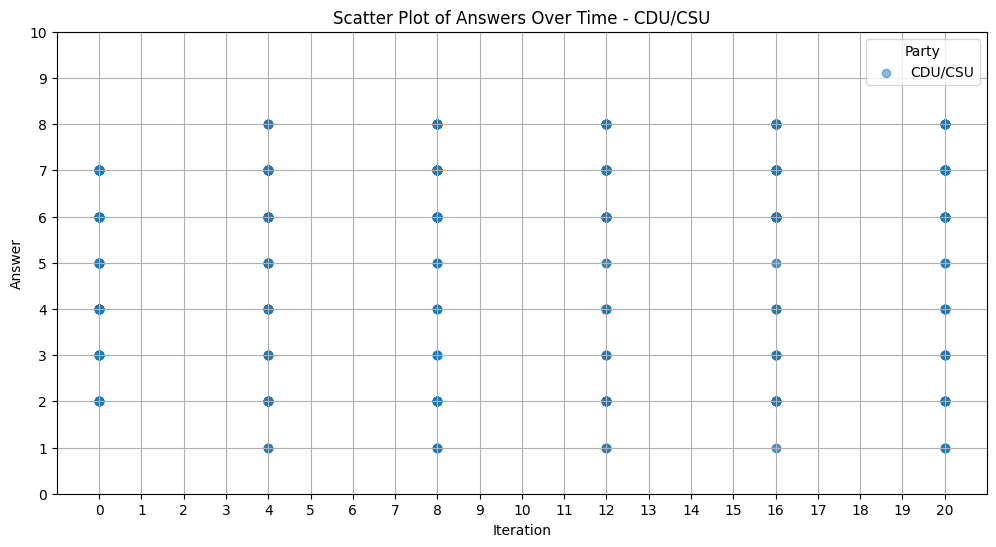

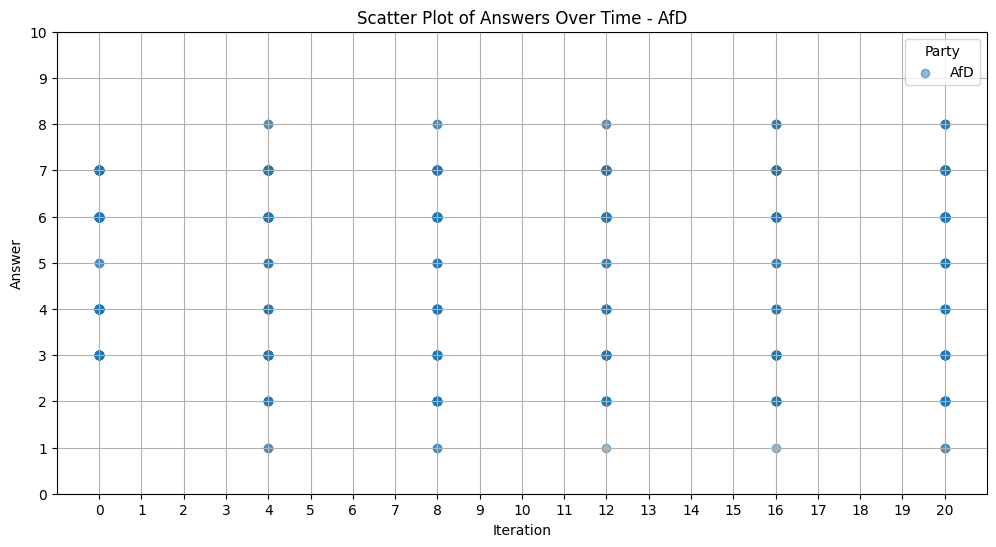

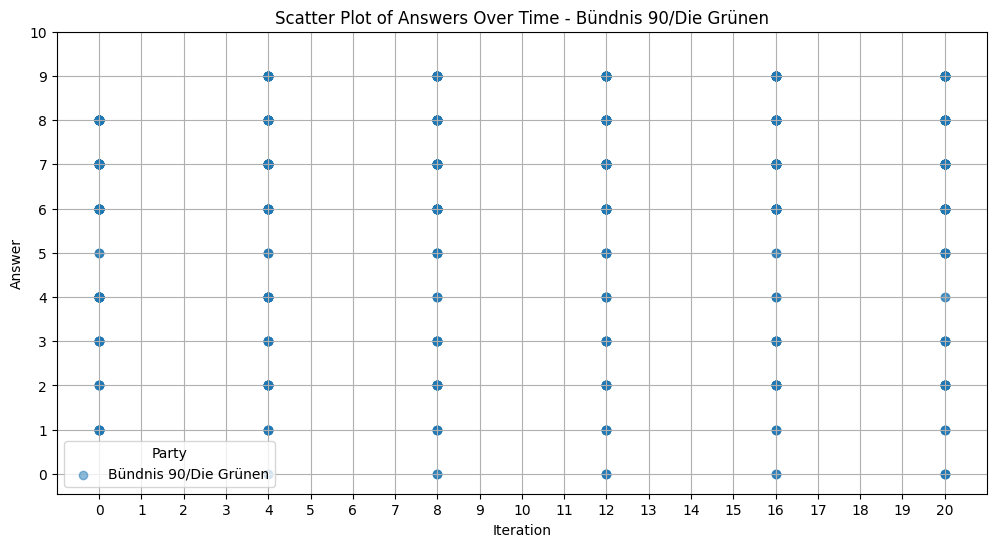

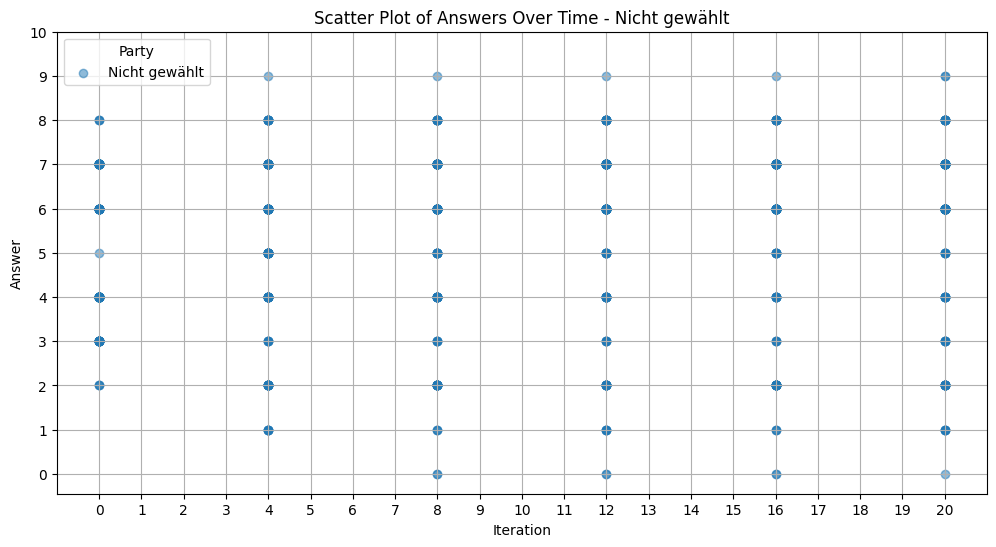

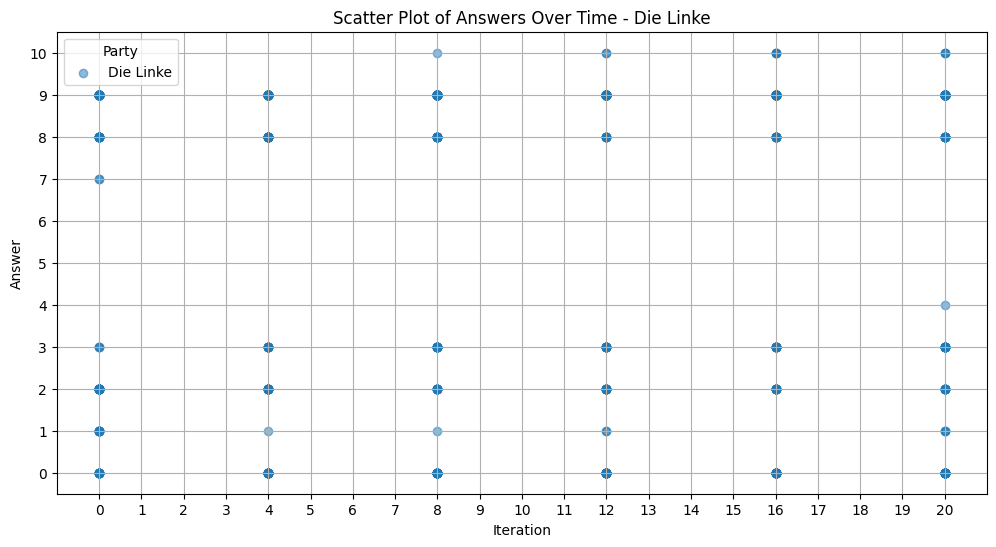

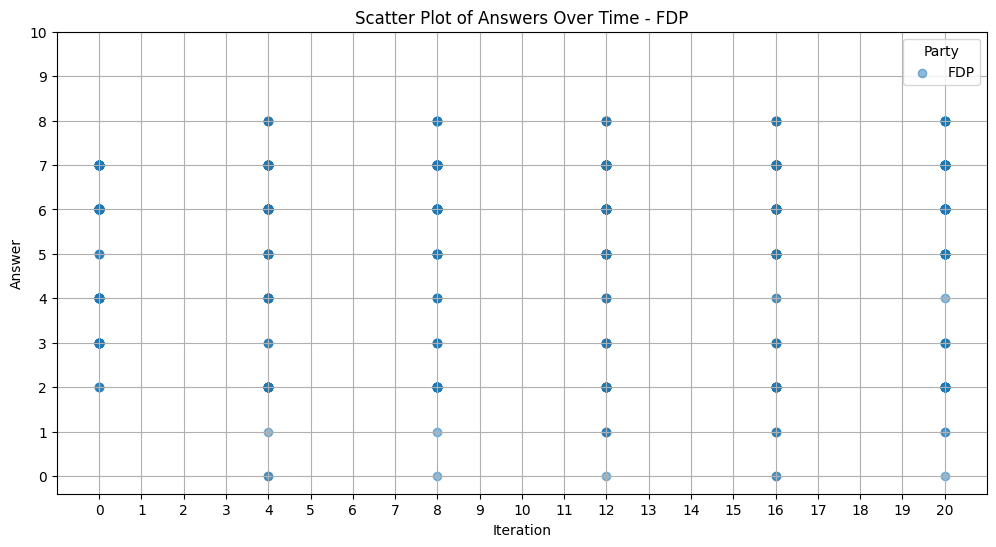

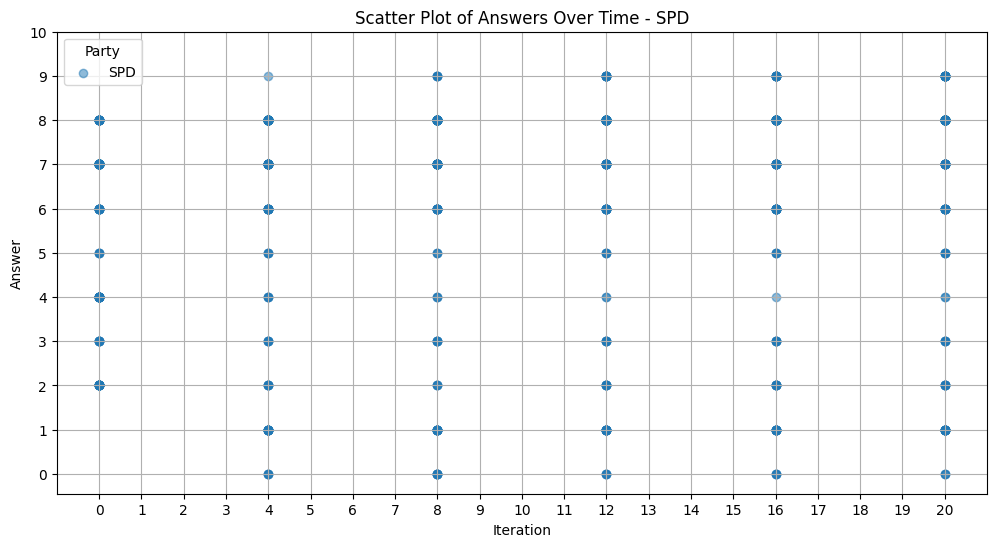

In [34]:
# scatterplot the data, answer over time
import matplotlib.pyplot as plt

plot_df = party_df_non_abs.copy()

plot_df["iteration"] = plot_df["iteration"].str.replace("T", "").astype(int)
plot_df["answer"] = pd.to_numeric(plot_df["answer"], errors="coerce")

# Create a scatter plot for each party separately
for party in plot_df["party"].unique():
    party_data = plot_df[plot_df["party"] == party]
    plt.figure(figsize=(12, 6))
    plt.scatter(party_data["iteration"], party_data["answer"], label=party, alpha=0.5)
    plt.title(f"Scatter Plot of Answers Over Time - {party}")
    plt.xticks(range(0, 21))
    plt.yticks(range(0, 11))
    plt.xlabel("Iteration")
    plt.ylabel("Answer")
    plt.legend(title="Party")
    plt.grid()
    plt.show()

In [35]:
party_df_non_abs

,party,debate_with,version,question_index,iteration,answer
0,CDU/CSU,AfD,out_0,0,T0,7
1,AfD,CDU/CSU,out_0,0,T0,7
2,Bündnis 90/Die Grünen,Nicht gewählt,out_0,0,T0,7
3,Nicht gewählt,Bündnis 90/Die Grünen,out_0,0,T0,7
4,Bündnis 90/Die Grünen,AfD,out_0,0,T0,7
...,...,...,...,...,...,...
5035,CDU/CSU,SPD,out_2,4,T20,8
5036,SPD,FDP,out_2,4,T20,8
5037,FDP,SPD,out_2,4,T20,7
5038,FDP,CDU/CSU,out_2,4,T20,6


In [ ]:
# LMM - Linearly Mixed Model
# Model: answer ~ iteration + party + version, random intercept for agent_idx within party

import statsmodels.api as sm
import statsmodels.formula.api as smf


# remove nan
lmm_data = party_df_non_abs.dropna(subset=["answer"]).reset_index(drop=True)


lmm_data = lmm_data.dropna(subset=["answer"]).reset_index(drop=True)

lmm_data["answer"] = pd.to_numeric(lmm_data["answer"], errors="coerce")
lmm_data["time"] = lmm_data["iteration"].str.extract(r"T(\d+)").astype(float)

# reset index
lmm_data = lmm_data.reset_index(drop=True)

groups = (
    lmm_data["party"]
    + "_"
    + lmm_data["debate_with"].astype(str)
    + "_"
    + lmm_data["version"].astype(str)
)

# categorize the question_index
lmm_data["question_index"] = lmm_data["question_index"].astype("category")


md = smf.mixedlm(
    "answer ~ time + party*question_index + time * question_index + version",
    lmm_data,
    groups=groups,
)
mdf = md.fit()
print(mdf.summary())‚

                            Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             answer    
No. Observations:               5040                Method:                         REML      
No. Groups:                     147                 Scale:                          0.8709    
Min. group size:                30                  Log-Likelihood:                 -6946.1497
Max. group size:                60                  Converged:                      Yes       
Mean group size:                34.3                                                          
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           5.934    0.108  54.752 0.00